# Load the required packages

In [1]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split   

from tensorflow.keras import models, layers 
from tensorflow.keras.callbacks import EarlyStopping

2023-06-14 11:46:44.098323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Processed Data

### Load meta data

In [2]:
data = pd.read_csv('../processed_data/ISIC_2019_Training_GroundTruth_Processed_Balanced.csv')
data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,Cat,y
0,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
1,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
2,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
3,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
4,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0


the shape of the processed data setis (24806, 12)


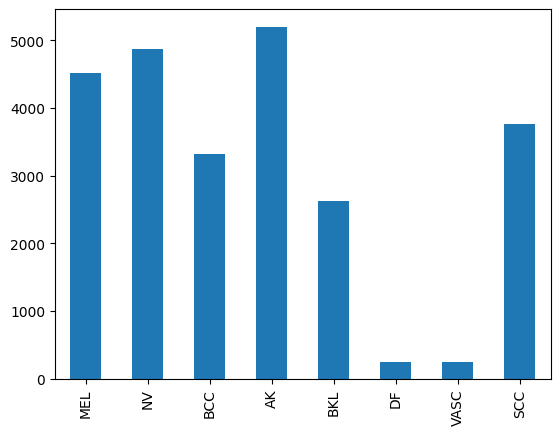

In [3]:
print(f'the shape of the processed data setis {data.shape}')
data.sum()[1:9].plot.bar();

### Load image data

In [5]:
def get_image(item):
    file_name = f"../processed_data/{item['Cat']}/{item['image']}.jpg"
    image = Image.open(file_name)
    width, height=image.size
    assert (width==400 and height==400), f"image: {file_name}, width: {width}, height: {height}"
    return np.asarray(image, dtype=np.float32)

n_samples=10000; sample = data.sample(n_samples, random_state=42)
# sample = data #load the full dataset

X = sample.apply(get_image, axis=1)
X = np.stack(X)
y = sample.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000, 400, 400, 3) (3000, 400, 400, 3) (7000,) (3000,)


# Modeling

## Create Model

In [7]:
def initialize_model():
    
    model = models.Sequential()

    model.add(layers.Conv2D(16, (3, 3), input_shape = (400,400,3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding='same' ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (2, 2), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units = 100, activation = 'relu'))
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics =['accuracy', 'Recall'])   

    return model

model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 64)       0

## Train Model

In [8]:
es = EarlyStopping(patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split = 0.3,
    batch_size = 16,
    epochs=10,
    callbacks=[es],
    verbose = 1)

Epoch 1/10
307/307 [==============================] - 322s 1s/step - loss: 3.1727 - accuracy: 0.6684 - recall: 0.9355 - val_loss: 0.6043 - val_accuracy: 0.6771 - val_recall: 0.9979
Epoch 2/10
307/307 [==============================] - 323s 1s/step - loss: 0.6098 - accuracy: 0.6796 - recall: 0.9340 - val_loss: 0.6062 - val_accuracy: 0.7138 - val_recall: 0.9726
Epoch 3/10
307/307 [==============================] - 324s 1s/step - loss: 0.6298 - accuracy: 0.6827 - recall: 0.9283 - val_loss: 0.5989 - val_accuracy: 0.6833 - val_recall: 0.9958
Epoch 4/10
307/307 [==============================] - 301s 979ms/step - loss: 0.5997 - accuracy: 0.6967 - recall: 0.9337 - val_loss: 0.6200 - val_accuracy: 0.6771 - val_recall: 0.9972
Epoch 5/10
307/307 [==============================] - 327s 1s/step - loss: 0.6038 - accuracy: 0.6988 - recall: 0.9235 - val_loss: 0.5992 - val_accuracy: 0.7138 - val_recall: 0.9368
Epoch 6/10
307/307 [==============================] - 308s 1000ms/step - loss: 0.5763 - accu

## Evaluate Model

In [9]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_int = np.round(y_pred).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt

cm = confusion_matrix(y_test, y_pred_int)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

94/94 [==============================] - 59s 618ms/step - loss: 0.5993 - accuracy: 0.6683 - recall: 0.7737


[0.599257230758667, 0.6683333516120911, 0.7737047672271729]

# Save the trained model

In [ ]:
# Serialize the trained model
model_name= 'model_dummy'
import pickle
file_name_pickle = f'../{model_name}.pickle'
with open(file_name_pickle, 'wb') as file:
    pickle.dump(model, file)